# CF2, Part1

In [33]:
import numpy as np
import matplotlib.pyplot as plt

Monte Carlo to find the price of a European put option

In [17]:
def stockprices_and_payoff(S0, K, r, T, sigma, M):
    # Calculate the time step size
    dt = T / M                      

    # Calculate the stock price evolution using Euler's method
    S = np.zeros(M+1)
    S[0] = S0
    for t in range(1, M+1):
        Z = np.random.normal(0, 1)
        S[t] = S[t-1] + S[t-1] * (r * dt + sigma * np.sqrt(dt) * Z) 

    # Find the payoff of the option at expiry
    ST = S[-1]
    payoff = np.maximum(ST-K, 0)
    return payoff


def average_payoffs(S0, K, r, T, sigma, M, num_simulations): # different ways to find payoff?
    payoffs = np.zeros(num_simulations)
    for i in range(1,num_simulations):
        payoffs[i] = stockprices_and_payoff(S0, K, r, T, sigma, M)

    average_payoff = np.mean(payoffs)
    standard_error = np.std(payoffs, ddof=1) / np.sqrt(num_simulations) # check what happens without the , ddof=1...
    return average_payoff, standard_error

# Parameters
S0 = 100  # Initial stock price
K = 99  # Strike price
r = 0.06  # Risk-free rate
T = 1  # Time to expiry is one year
sigma = 0.2  # Volatility
M = 365  # Number of timesteps in euler is 365 days 
num_simulations = 100  

average_payoff, standard_error = average_payoffs(S0, K, r, T, sigma, M, num_simulations)
# Discount the present value
pi = np.exp(-r * T) * average_payoff

print("The average payoff is:", average_payoff)
print("The price of the European call option is:", pi)
print("The standard error of the option price is:", standard_error)



The average payoff is: 13.756280258688955
The price of the European call option is: 12.955176861678412
The standard error of the option price is: 1.7178548210014006


Convergence study by increasing the number of simulations

In [43]:

num_simulations_range = np.arange(100,10000,10) # set 10 000 instead of 1000 for the resut in report
pi_values = []    # To store the results
standard_error_values = []    # To store the results


for num_simulations in num_simulations_range:
    average_payoff, standard_error = average_payoffs(S0, K, r, T, sigma, M, num_simulations)
    pi = np.exp(-r * T) * average_payoff
    pi_values.append(pi)
    standard_error_values.append(standard_error)
    
convergence_value = np.mean(pi_values)
print("The call option converges to:", convergence_value)

plt.plot(num_simulations_range, pi_values)
plt.xlabel('Number of trials')
plt.ylabel('Price of call option')
plt.title('Convergence of European call option price')
plt.show()

plt.plot(num_simulations_range, standard_error_values)
plt.xlabel('Number of trials')
plt.ylabel('Root mean square error')
plt.title('Standard error of an option price')
plt.show()
    
    

Compare to BS and binomial tree - or only one of them? Compare to their convergence

Varying the strike price

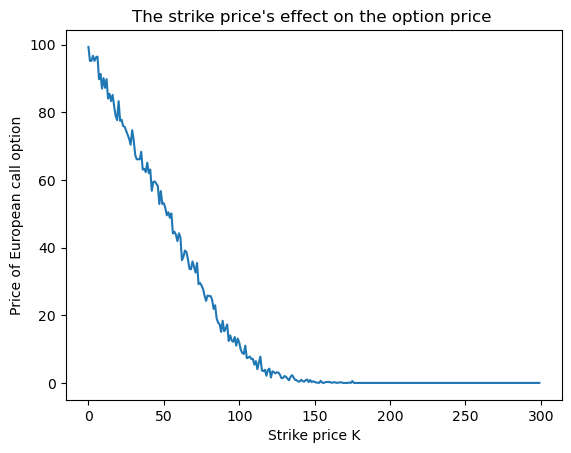

In [30]:


strike_price_range = np.arange(0,300,1) # set 500 instead of 50 for the resut in report
pi_values = []    # To store the results

for strike_price in strike_price_range:
    average_payoff,_ = average_payoffs(S0, strike_price, r, T, sigma, M, num_simulations)
    pi = np.exp(-r * T) * average_payoff
    pi_values.append(pi)

plt.plot(strike_price_range, pi_values)
plt.xlabel('Strike price K')
plt.ylabel('Price of European call option')
plt.title("The strike price's effect on the option price ")
plt.show()
    

Varying the volatility

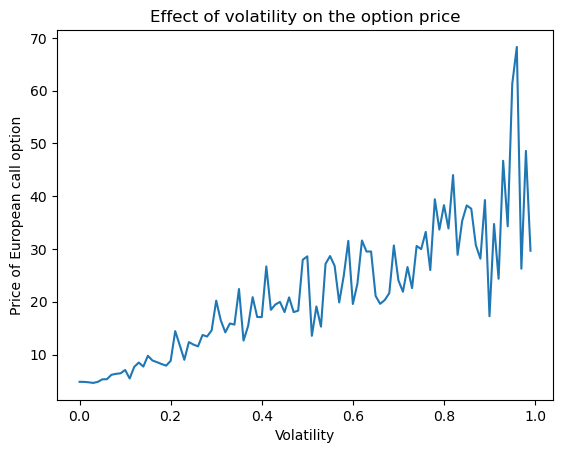

In [29]:
volatility_range = np.arange(0,1,0.01) # set 0.01 instead of 0.1 for the resut in report 
pi_values = []    # To store the results

for volatility in volatility_range:
    average_payoff,_ = average_payoffs(S0, K, r, T, volatility, M, num_simulations)
    pi = np.exp(-r * T) * average_payoff
    pi_values.append(pi)

plt.plot(volatility_range, pi_values)
plt.xlabel('Volatility')
plt.ylabel('Price of European call option')
plt.title('Effect of volatility on the option price')
plt.show()
    

What is the standard error of your estimate and what does this tell you about the accuracy?

Ignore this below: i've included it above

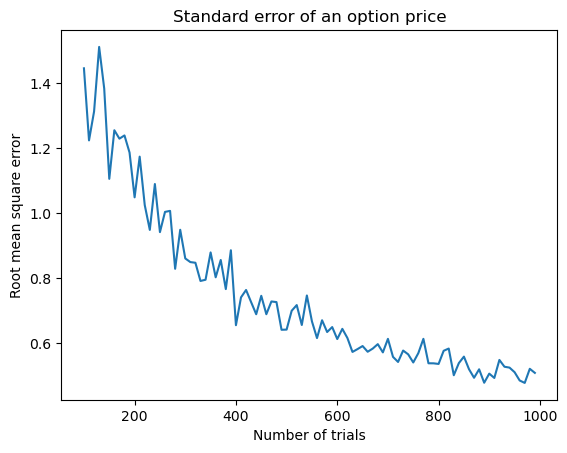

In [32]:
num_simulations_range = np.arange(100,1000,10)
standard_error_values = []    # To store the results

for num_simulations in num_simulations_range:
    _,standard_error = average_payoffs(S0, K, r, T, sigma, M, num_simulations)
    standard_error_values.append(standard_error)

plt.plot(num_simulations_range, standard_error_values)
plt.xlabel('Number of trials')
plt.ylabel('Root mean square error')
plt.title('Standard error of an option price')
plt.show()
    

# Part B

 Implement the Milstein Scheme for the Heston Model

Write a function to simulate asset price and variance paths using the Milstein scheme for the given
Heston model parameters:

risk-free rate r = 005, long-term variance = 004, mean reversion rate = 2, vol-of-vol = 01, and correlation = 07. 

Use a time step t =1/252 to represent daily changes.

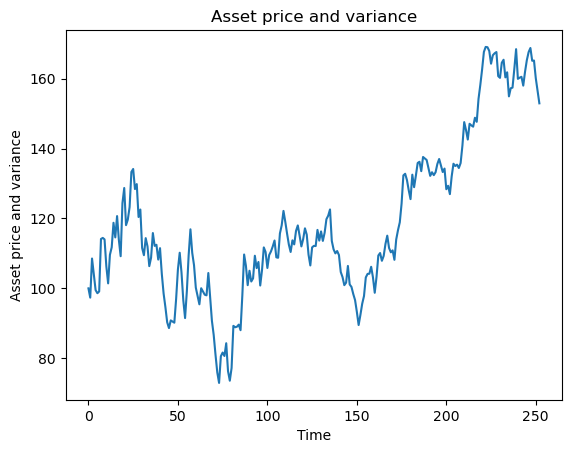

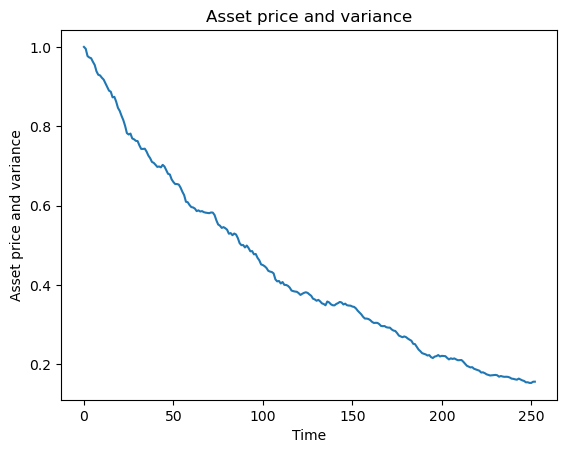

In [34]:

def milstein_scheme_heston(r, theta, kappa, xi, rho, S0, v0, K, T, barrier, M):
    dt = T / M
    
    S_path = np.zeros(M+1)  # To store the asset price path     
    v_path = np.zeros(M+1)  # To store the variance path
    exceeded_barrier = False
    
    # Set initial values
    S_path[0] = S0
    v_path[0] = v0
    
    for i in range(1, M+1):
        # Generate random normal variables
        Z_v = np.random.normal(0, 1)
        Z_S = rho * Z_v + np.sqrt(1 - rho**2) * np.random.normal(0, 1)

        # Update the asset price
        S_path[i] = S_path[i-1] + r*S_path[i-1]*dt + np.sqrt(v_path[i-1]*dt)*S_path[i-1]*Z_S + 0.5*v_path[i-1]*S_path[i-1]*dt*(Z_S**2 - 1)
        
        # Update the variance
        v_path[i] = np.maximum(v_path[i-1] + kappa*(theta-v_path[i-1])*dt + xi*np.sqrt(v_path[i-1]*dt)*Z_v + 0.25*(xi**2)*dt*(Z_v**2 - 1), 0)
        
        # Check for barrier event
        if S_path[i] > barrier:
            exceeded_barrier = True
        
    # Find the payoff of the option at expiry
    ST = S_path[-1]
    payoff = np.maximum(ST-K, 0)
    if exceeded_barrier == True:
        payoff = 0
    
    return S_path, v_path, payoff

# Heston model parameters
r = 0.05
theta = 0.04
kappa = 2
vol_of_vol = 0.1
rho = -0.7
K = 100
barrier = 120
num_steps = 252  # Daily changes, except for the weekends
T = 1

S0 = 100 # just use the same as before? isn't specified?
v0 = 1
 

# Simulate asset price and variance paths
S_path, v_path, payoff = milstein_scheme_heston(r, theta, kappa, vol_of_vol, rho, S0, v0, K, T, barrier, num_steps)


plt.plot(range(num_steps+1), S_path)
plt.xlabel('Time')
plt.ylabel('Asset price and variance')
plt.title('Asset price and variance')
plt.show()

plt.plot(range(num_steps+1), v_path) # better to plot the variance from the asset price??
plt.xlabel('Time')
plt.ylabel('Asset price and variance')
plt.title('Asset price and variance')
plt.show()




 Simulate Paths and Handle the Barrier Feature: Simulate 10,000 paths for
 the underlying asset over a 1-year period. Implement the barrier feature by setting
 the option value to 0 if the asset price exceeds the barrier level B at any time during
 the options life.

In [35]:
num_simulations = 100 # The amount of repetitions - gotta change this to 10000 later

def average_payoffs_milstein(r, theta, kappa, vol_of_vol, rho, S0, v0, K, T, barrier, num_steps, num_simulations):
    payoffs = np.zeros(num_simulations)
    for i in range(1,num_simulations):
        _,_,payoff = milstein_scheme_heston(r, theta, kappa, vol_of_vol, rho, S0, v0, K, T, barrier, num_steps)
        payoffs[i] = payoff

    average_payoff = np.mean(payoffs)
    #standard_error = np.std(payoffs, ddof=1) / np.sqrt(num_simulations)
    return average_payoff



 Price the Barrier Option: For the option pricing, assume a strike price K = 100
 and a barrier level B = 120. Use the simulated paths to estimate the options price,
 discounting the average payoff at maturity back to the present value using the risk-free
 rate.

Basically just implement the simulation

In [36]:

average_payoff = average_payoffs_milstein(r, theta, kappa, vol_of_vol, rho, S0, v0, K, T, barrier, num_steps, num_simulations)
# Discount the present value
pi = np.exp(-r * T) * average_payoff   

print("Option price:", pi)

# why is the option so low?? is it normal? in part A we had option around 4 euros, now 0.17... 
# maybe because we have a barrier where the option becomes zero now
# Also why is the option 0.15 for B=120 and 0.17 for B=110? Should be more option zeros for a lower barrier and therefore a lower average option...
# and now, a day later, when i run this it's 0.05... even lower haha

Option price: 0.08875906946248051


Analysis: Discuss how the options price changes with different levels of the barrier
 B, correlation and the vol-of-vol parameters. Perform a sensitivity analysis by
 varying these parameters and observing the impact on the option price. Present your findings using plots

Find option price for ranges of: B, rho (p), xi

-> how do i quantify the sensitivity? Well says just to use plots!

Varying the barrier B

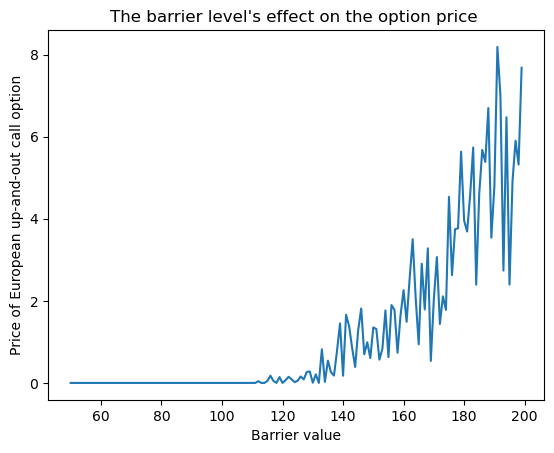

In [37]:
barrier_range = np.arange(50,200,1)
pi_values = []    # To store the results

for barrier in barrier_range:
    average_payoff = average_payoffs_milstein(r, theta, kappa, vol_of_vol, rho, S0, v0, K, T, barrier, num_steps, num_simulations)

    pi = np.exp(-r * T) * average_payoff
    pi_values.append(pi)

plt.plot(barrier_range, pi_values)
plt.xlabel('Barrier value')
plt.ylabel('Price of European up-and-out call option')
plt.title("The barrier level's effect on the option price ")
plt.show()
    

Varying the rho value

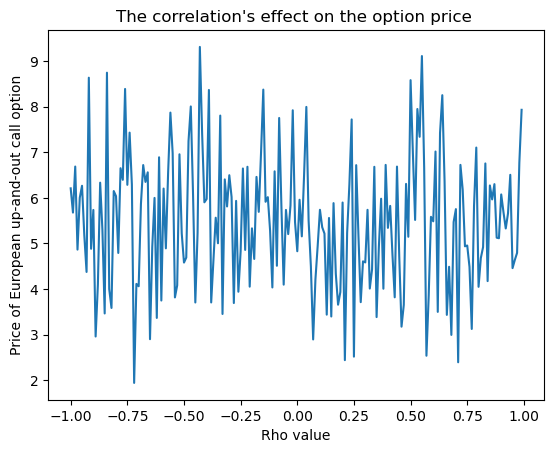

In [38]:
rho_range = np.arange(-1,1,0.01) 
pi_values = []    # To store the results

for rho in rho_range:
    average_payoff = average_payoffs_milstein(r, theta, kappa, vol_of_vol, rho, S0, v0, K, T, barrier, num_steps, num_simulations)

    pi = np.exp(-r * T) * average_payoff
    pi_values.append(pi)

plt.plot(rho_range, pi_values)
plt.xlabel('Rho value')
plt.ylabel('Price of European up-and-out call option')
plt.title("The correlation's effect on the option price ")
plt.show()
    

Varying xi

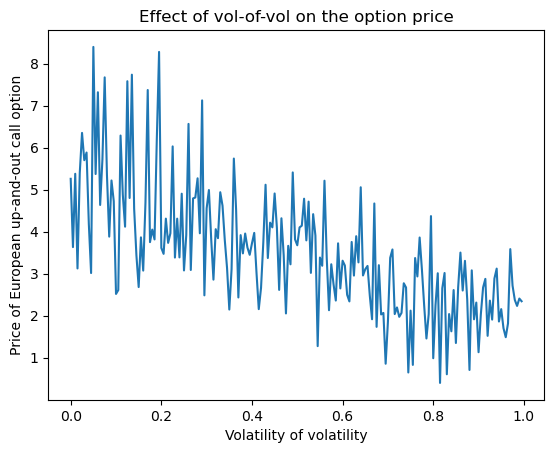

In [39]:
xi_range = np.arange(0,1,0.005)
pi_values = []    # To store the results

for xi in xi_range:
    average_payoff = average_payoffs_milstein(r, theta, kappa, xi, rho, S0, v0, K, T, barrier, num_steps, num_simulations)

    pi = np.exp(-r * T) * average_payoff
    pi_values.append(pi)

plt.plot(xi_range, pi_values)
plt.xlabel('Volatility of volatility')
plt.ylabel('Price of European up-and-out call option')
plt.title("Effect of vol-of-vol on the option price")
plt.show()
    